In [19]:
from ionqvision.ansatze.ansatz_library import AngleEncoder
from qiskit.circuit.library import EfficientSU2, TwoLocal, RealAmplitudes
from qiskit.circuit.library import ZFeatureMap, ZZFeatureMap, PauliFeatureMap
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from ansatz_library import AngleEncoder
import numpy as np


from ionqvision.ansatze import VariationalAnsatz

In [20]:
class CustomZFeatureMapEncoder(VariationalAnsatz):
    """
        Implement a quantum circuit for ZFeatureMap encoding
    """
    def __init__(self, num, reps = 1, param_prefix="x"):
        super().__init__(num)

        x = ParameterVector(param_prefix, num)
        self.compose(ZFeatureMap(num, reps=reps, insert_barriers=True).decompose(), inplace = True)

In [22]:
class CustomTwoLocal(VariationalAnsatz):
    """
    Implement a quantum circuit for setting up the Two Local Ansatz
    """
    def __init__(self, num_qubits, reps, entanglement, rotation_blocks, entanglement_blocks,param_prefix="θ"):
        super().__init__(num_qubits)

        theta = ParameterVector(param_prefix, num_qubits)
        self.compose(TwoLocal(num_qubits=num_qubits, reps=reps, entanglement=entanglement, rotation_blocks=rotation_blocks, entanglement_blocks=entanglement_blocks,
                              insert_barriers=True).decompose(), inplace = True)

In [24]:
## initializing two qubits
n = 2

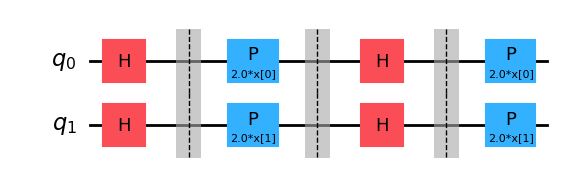

In [25]:
# building the encoder
encoder = CustomZFeatureMapEncoder(n, reps = 2)
encoder.draw("mpl")

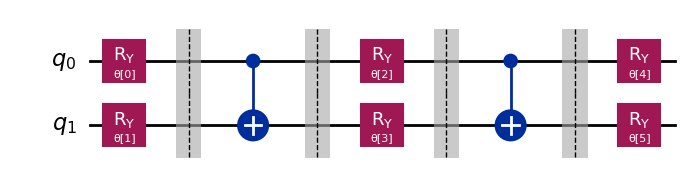

In [27]:
# implementing the ansatz
ansatz = CustomTwoLocal(num_qubits=n,reps=2, entanglement="linear", entanglement_blocks="cx", rotation_blocks="ry")
ansatz.draw("mpl")

In [28]:
from qiskit.quantum_info import SparsePauliOp

# Measure the expectation value of ZI
def feature_creation(n):
    if n % 2 == 0:
        return [SparsePauliOp(["ZI"*(n//2)])]
    else:
        return [SparsePauliOp(["ZI"*(n//2) + "Z"])]
           # SparsePauliOp(["YXYX"])]
            # SparsePauliOp(["I"*(n-1) + "X"]), 
            # SparsePauliOp(["I"*(n-1) + "Y"])]

quantum_features = feature_creation(n)

In [29]:
quantum_features

[SparsePauliOp(['ZI'],
               coeffs=[1.+0.j])]

In [30]:
from ionqvision.modules import BinaryMNISTClassifier

# Set up your classifier and inspect its architecture
classifier = BinaryMNISTClassifier(encoder, ansatz, quantum_features);

In [31]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

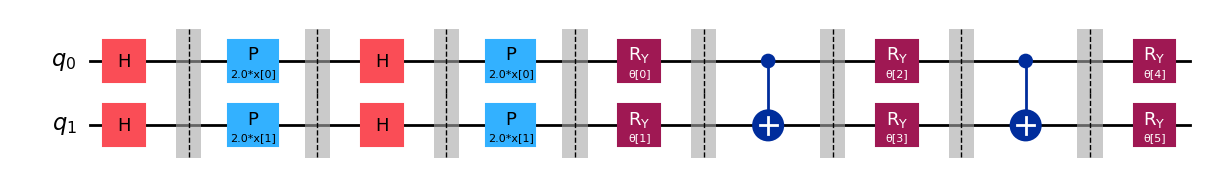

In [32]:
# Check out your quantum layer
classifier.quantum_layer.layer_qc.draw("mpl")

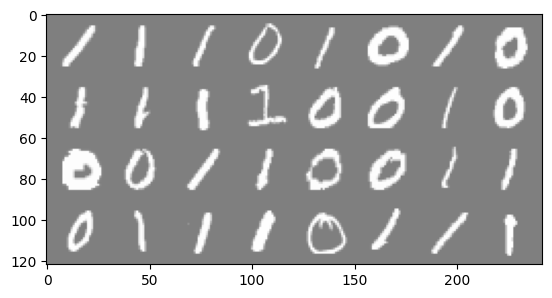

In [33]:
# Verify the images loaded correctly
classifier.visualize_batch()

In [34]:
%%time
# Get a (pre-processed) training and test set
train_set, test_set = classifier.get_train_test_set(train_size=300, test_size=100)

train_set

CPU times: user 92.5 ms, sys: 84 ms, total: 177 ms
Wall time: 149 ms


Dataset MNIST
    Number of datapoints: 300
    Root location: ./mnist-train
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )

In [35]:
train_set[0][0].shape

torch.Size([1, 28, 6])

epoch:   1 | loss: 0.720
lr: 0.1000 | processed    12/   12 batches per epoch in 30.81s (0.13s forward / 2.27s backward)
Model achieved 52.333%  accuracy on TRAIN set.
Model achieved 57.000%  accuracy on TEST set.

epoch:   2 | loss: 0.691
lr: 0.1000 | processed    12/   12 batches per epoch in 33.08s (0.13s forward / 2.35s backward)
Model achieved 61.333%  accuracy on TRAIN set.
Model achieved 63.000%  accuracy on TEST set.

epoch:   3 | loss: 0.695
lr: 0.1000 | processed    12/   12 batches per epoch in 31.93s (0.15s forward / 2.34s backward)
Model achieved 55.667%  accuracy on TRAIN set.
Model achieved 67.000%  accuracy on TEST set.



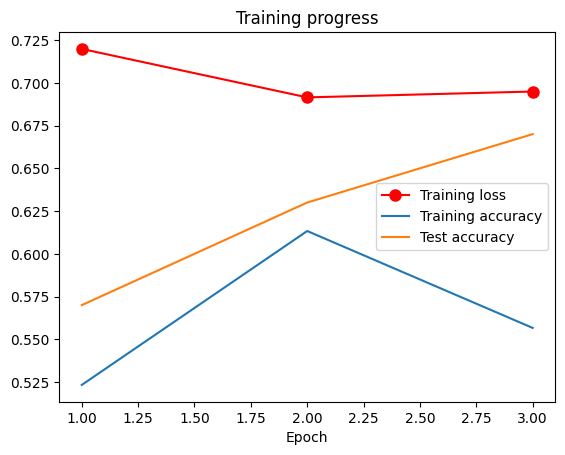

In [36]:
# Configure model training hyper parameters
config = {
    "epochs": 3,
    "lr": 0.1,
    "batch_size": 25,
    "betas": (0.9, 0.99),
    "weight_decay": 1e-3,
    "clip_grad": True,
    "log_interval": 12,
}

# Train and plot the results

classifier.train_module(train_set, test_set, config)
classifier.plot_training_progress()

In [37]:
from qbraid.runtime import QbraidSession
from ionqvision.scq_client import IonQSCQClient

session = QbraidSession()

client = IonQSCQClient(session=session)

In [38]:
submission_data = classifier.submit_model_for_grading(client=client)

message = submission_data.get("message")
submission_id = submission_data.get("submissionId")

print(message)

Submission received. Autograder in progress.


In [39]:
client.await_autograder_result(submission_id=submission_id)

{'_id': '670a03862e918b6a0fc370ea',
 'submittedBy': 'ganiyubaraq@gmail.com',
 'status': 'succeeded',
 'statusMessage': 'Submission graded successfully.',
 'executionId': 'ionq-scquantum-ck4sq',
 'executionSec': 57,
 'score': 65,
 'createdAt': '2024-10-12T05:05:11.814Z',
 'updatedAt': '2024-10-12T05:05:11.814Z',
 'success': True}